### Importing Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [2]:
data = pd.read_csv("D:\\Metro_Interstate_Traffic_Volume.csv", infer_datetime_format=True) 

In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data.describe(include = 'all')

holiday          temp       rain_1h       snow_1h    clouds_all  \
count    48204  48204.000000  48204.000000  48204.000000  48204.000000   
unique      12           NaN           NaN           NaN           NaN   
top       None           NaN           NaN           NaN           NaN   
freq     48143           NaN           NaN           NaN           NaN   
first      NaN           NaN           NaN           NaN           NaN   
last       NaN           NaN           NaN           NaN           NaN   
mean       NaN    281.205870      0.334264      0.000222     49.362231   
std        NaN     13.338232     44.789133      0.008168     39.015750   
min        NaN      0.000000      0.000000      0.000000      0.000000   
25%        NaN    272.160000      0.000000      0.000000      1.000000   
50%        NaN    282.450000      0.000000      0.000000     64.000000   
75%        NaN    291.806000      0.000000      0.000000     90.000000   
max        NaN    310.070000   9831.300000      0.510000    100.000000   

       weather_main weather_description            date_time  traffic_volume  
count         48204               48204                48204    48204.000000  
unique           11                  38                40575             NaN  
top          Clouds        sky is clear  2013-05-19 10:00:00             NaN  
freq          15164               11665                    6             NaN  
first           NaN                 NaN  2012-10-02 09:00:00             NaN  
last            NaN                 NaN  2018-09-30 23:00:00             NaN  
mean            NaN                 NaN                  NaN     3259.818355  
std             NaN                 NaN                  NaN     1986.860670  
min             NaN                 NaN                  NaN        0.000000  
25%             NaN                 NaN                  NaN     1193.000000  
50%             NaN                 NaN                  NaN     3380.000000  
75%             NaN                 NaN                  NaN     4933.000000  
max             NaN                 NaN                  NaN     7280.000000

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [6]:
ts = data['2018-08-30':'2018-09-29']

In [7]:
ts.head()

holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2018-08-30 00:00:00    None  286.24     0.25      0.0           1   
2018-08-30 01:00:00    None  285.53     0.25      0.0           1   
2018-08-30 02:00:00    None  285.35     0.25      0.0           1   
2018-08-30 03:00:00    None  285.33     0.25      0.0           1   
2018-08-30 04:00:00    None  285.49     0.25      0.0           1   

                    weather_main weather_description                  ds  \
date_time                                                                  
2018-08-30 00:00:00         Rain          light rain 2018-08-30 00:00:00   
2018-08-30 01:00:00         Rain          light rain 2018-08-30 01:00:00   
2018-08-30 02:00:00         Rain          light rain 2018-08-30 02:00:00   
2018-08-30 03:00:00         Rain          light rain 2018-08-30 03:00:00   
2018-08-30 04:00:00         Rain          light rain 2018-08-30 04:00:00   

                     traffic_volume  
date_time                            
2018-08-30 00:00:00             670  
2018-08-30 01:00:00             456  
2018-08-30 02:00:00             326  
2018-08-30 03:00:00             388  
2018-08-30 04:00:00            1008

In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2018-08-30 00:00:00 to 2018-09-29 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              744 non-null    object        
 1   temp                 744 non-null    float64       
 2   rain_1h              744 non-null    float64       
 3   snow_1h              744 non-null    float64       
 4   clouds_all           744 non-null    int64         
 5   weather_main         744 non-null    object        
 6   weather_description  744 non-null    object        
 7   ds                   744 non-null    datetime64[ns]
 8   traffic_volume       744 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 58.1+ KB


### Train/Test split

In [9]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [10]:
len(ts_train), len(ts_test)

(553, 191)

### Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
window = 24*7
cutoff = 0.05
def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

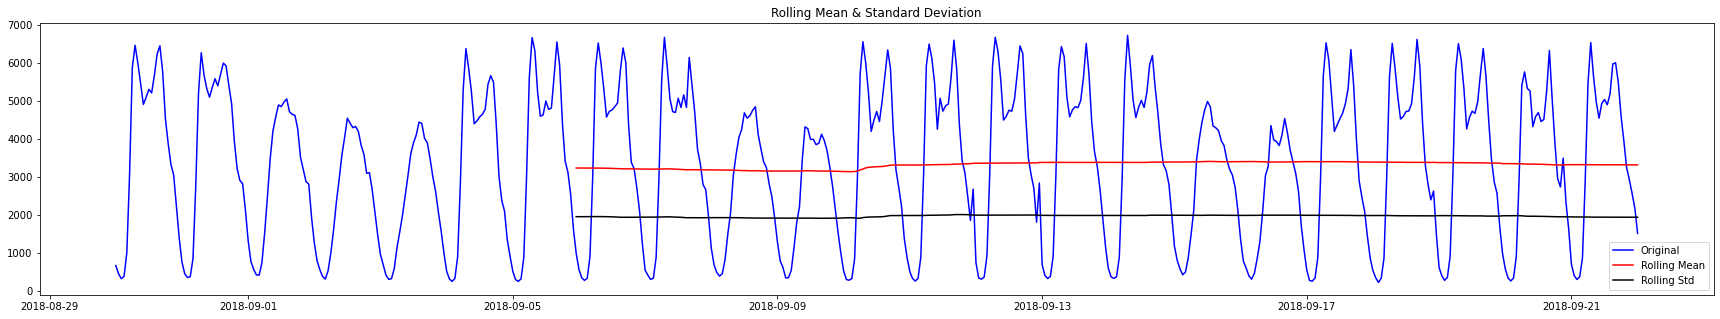

Results of Dickey-Fuller Test:
p-value = 0.0698. The series is likely non-stationary.
Test Statistic                  -2.725073
p-value                          0.069799
#Lags Used                      24.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [12]:
test_stationarity(ts_train.traffic_volume)

### Building a model

In [13]:
# ACF and PACF plots
lag = 24
lag_pacf = pacf(ts_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(ts_train.traffic_volume, nlags=lag)

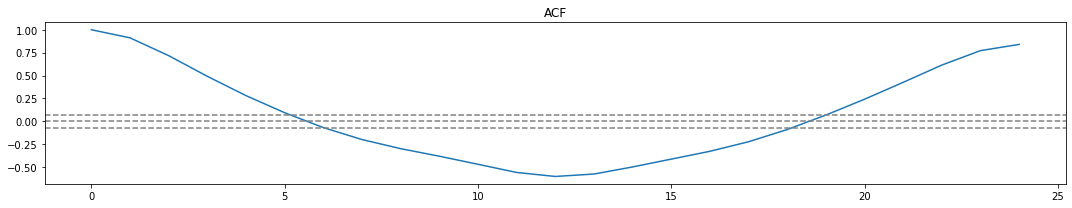

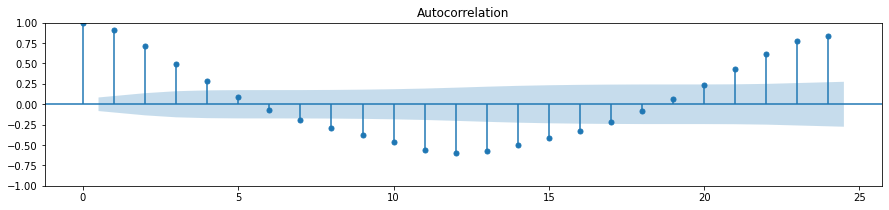

In [14]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

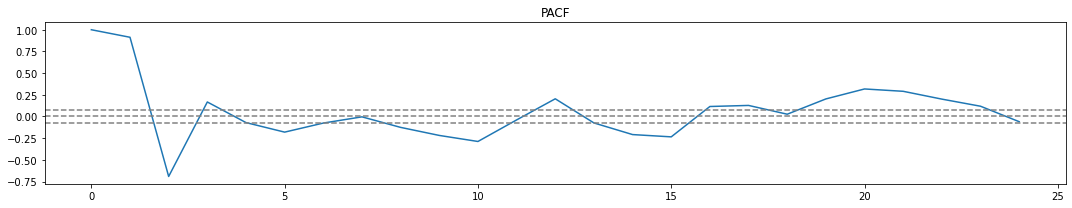

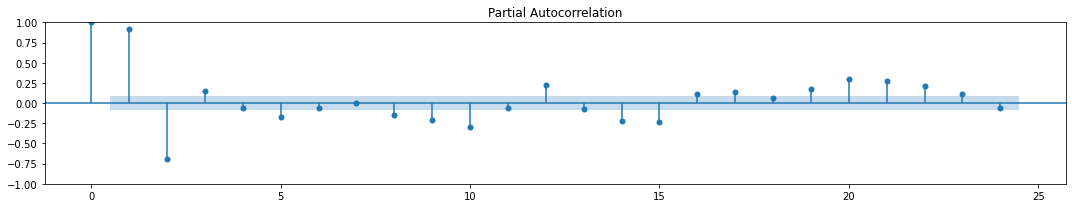

In [15]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train.traffic_volume, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [16]:
p=2
d=0
q=1


### ARIMA Model

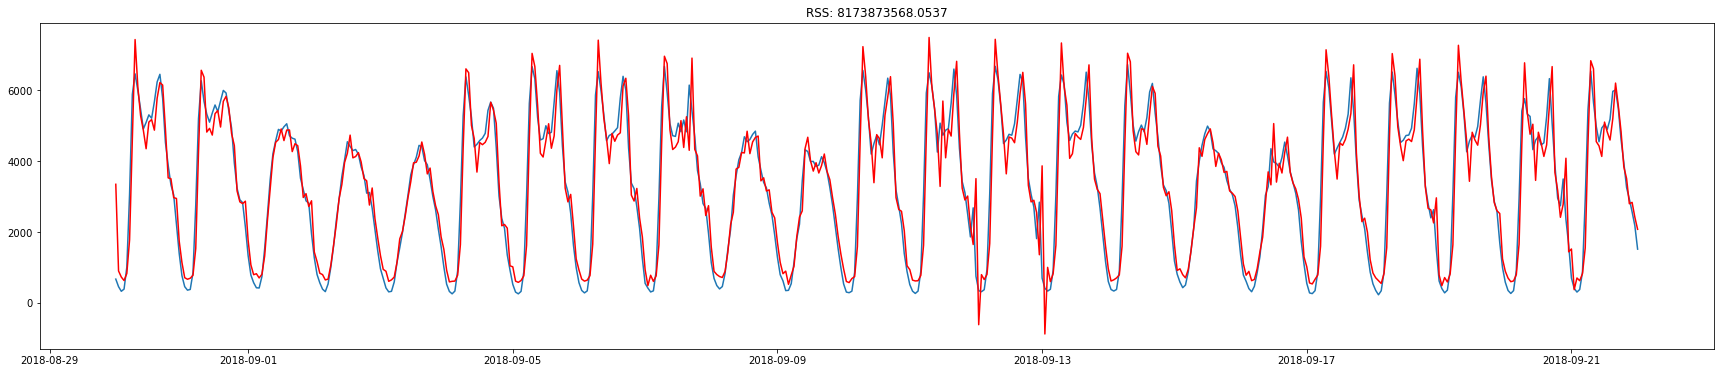

CPU times: total: 125 ms
Wall time: 313 ms


In [17]:
%%time
# ARIMA
model = ARIMA(ts_train.traffic_volume, order=(p, d, q))  
#model = ARIMA(ts_train, order=(1, 0, 1)) 
results_ARIMA = model.fit()
plt.figure(figsize=(30,6))
plt.plot(ts_train.traffic_volume)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show() 

In [18]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                  553
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4294.084
Date:                Sun, 28 May 2023   AIC                           8598.169
Time:                        05:21:56   BIC                           8619.746
Sample:                    08-30-2018   HQIC                          8606.599
                         - 09-22-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3346.8915    211.892     15.795      0.000    2931.590    3762.193
ar.L1          1.4305      0.049     29.370      0.000       1.335       1.526
ar.L2         -0.5860      0.048    -12.233      0.000      -0.680      -0.492
ma.L1          0.2318      0.058      3.978      0.000       0.118       0.346
sigma2      3.243e+05   1.48e+04     21.870      0.000    2.95e+05    3.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               194.70
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

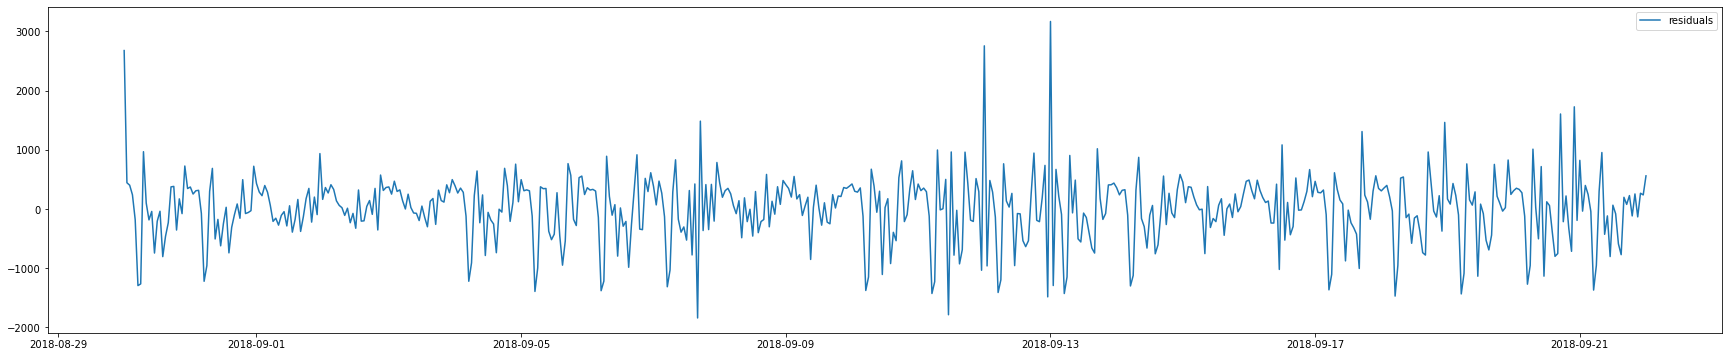

In [19]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train.traffic_volume
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

### Testing ARIMA on test set

In [20]:
def StartARIMAForecasting(Actual, p, d, q):
    model = ARIMA(Actual, order=(p, d, q))
    model_fit = model.fit()
    prediction = model_fit.forecast()[0]
    return prediction

In [21]:
len(ts_test.traffic_volume)

191

In [22]:
%%time
#new arrays to store actual and predictions
Actual = [x for x in ts_train.traffic_volume]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test.traffic_volume)):
    ActualValue =  ts_test.traffic_volume[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, p,d,q)    
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=1273.000000, Predicted=1282.372896
Actual=1207.000000, Predicted=1450.499736
Actual=611.000000, Predicted=1443.204571
Actual=647.000000, Predicted=489.347031
Actual=960.000000, Predicted=1118.963535
Actual=1635.000000, Predicted=1471.329721
Actual=2445.000000, Predicted=2328.668300
Actual=3415.000000, Predicted=3081.892807
Actual=3770.000000, Predicted=4046.719972
Actual=4308.000000, Predicted=3845.121492
Actual=4638.000000, Predicted=4577.674490
Actual=4831.000000, Predicted=4642.909437
Actual=4565.000000, Predicted=4755.404154
Actual=4654.000000, Predicted=4174.346288
Actual=4589.000000, Predicted=4611.845541
Actual=4582.000000, Predicted=4352.281954
Actual=4847.000000, Predicted=4438.450094
Actual=4620.000000, Predicted=4864.102060
Actual=4347.000000, Predicted=4234.431775
Actual=3602.000000, Predicted=4058.043502
Actual=2985.000000, Predicted=3020.844720
Actual=2480.000000, Predicted=2669.234939
Actual=1871.000000, Predicted=2272.734624
Actual=1249.000000, Predicted=1647.310

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred[0])))

In [25]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, predictions)

Mean Absolute Error: 394.42
Root Mean Squared Error: 542.70
Mean Absolute percentage Error: 23.69 %


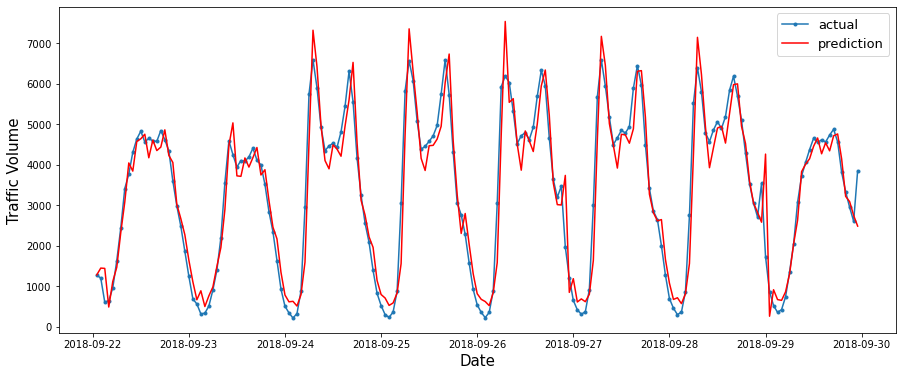

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(ts_test.index, ts_test.traffic_volume, marker='.', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

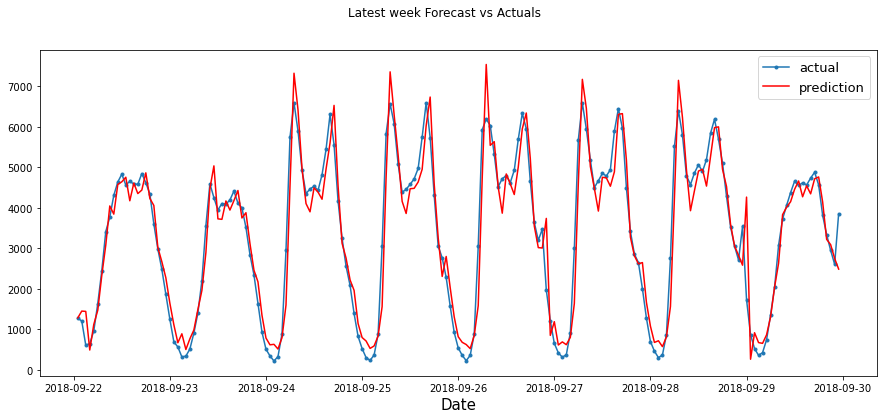

In [29]:
# zoom on lastest 2 days
plt.figure(figsize=(15, 6))
plt.plot(ts_test.index, ts_test.traffic_volume, marker='.', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
ax.set_xbound(lower=datetime.date(2018, 9, 27), upper=datetime.date(2018, 9, 29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Latest week Forecast vs Actuals')
plt.show()

### Auto ARIMA 

In [30]:
%%time
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ts_train.traffic_volume, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      max_P=3, max_Q=3,  # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                     n_fits = 50)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=9963.607, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=8959.811, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=10712.009, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=9345.111, Time=0.28 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=5.35 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=8837.609, Time=7.52 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=8824.436, Time=9.08 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=13.56 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=8775.105, Time=21.36 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=8782.450, Time=12.47 sec
 ARIMA(0,0,1)(2,0,3)[24] intercept   : AIC=inf, Time=20.65 sec
 ARIMA(0,0,0)(1,0,3)[24] intercept   : AIC=inf, Time=16.28 sec
 ARIMA(1,0,1)(1,0,3)[24] intercept   : AIC=

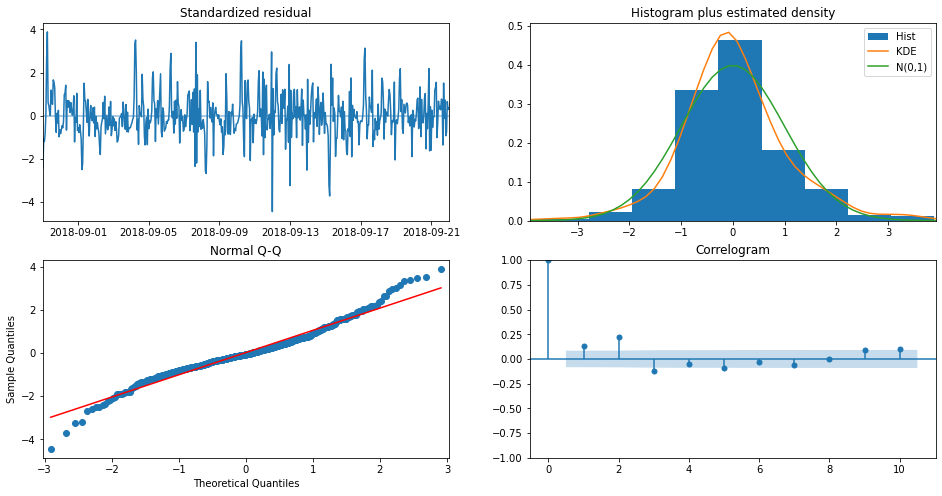

In [31]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [32]:
y_pred = model.predict(len(ts_test))

In [33]:
y_pred

2018-09-22 01:00:00    1273.058894
2018-09-22 02:00:00    1102.059132
2018-09-22 03:00:00    1089.327646
2018-09-22 04:00:00    1447.941193
2018-09-22 05:00:00    3049.554226
                          ...     
2018-09-29 19:00:00    3384.343197
2018-09-29 20:00:00    3141.506378
2018-09-29 21:00:00    3069.063013
2018-09-29 22:00:00    2788.175579
2018-09-29 23:00:00    2514.237865
Freq: H, Length: 191, dtype: float64

In [34]:
print('Test Mean Absolute Error:', mean_absolute_error(ts_test.traffic_volume, y_pred))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test.traffic_volume, y_pred)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test.traffic_volume, y_pred))

Test Mean Absolute Error: 895.3044822557329
Test Root Mean Squared Error: 1126.7254715640288
Test Mean Absolute percentage Error: 79.97243191238867


In [35]:
%%time
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ts_train.traffic_volume,order=(p,d,q),seasonal_order=(p,d,q, 24))
results=model.fit()

CPU times: total: 54.5 s
Wall time: 14.3 s


In [36]:
y_pred = pd.DataFrame(results.predict(len(ts_test)))

In [37]:
y_pred

predicted_mean
2018-09-06 23:00:00     1547.714736
2018-09-07 00:00:00      658.137643
2018-09-07 01:00:00      218.851388
2018-09-07 02:00:00      402.227440
2018-09-07 03:00:00      285.495141
...                             ...
2018-09-21 20:00:00     3668.781062
2018-09-21 21:00:00     3104.047332
2018-09-21 22:00:00     1951.227381
2018-09-21 23:00:00     2233.966656
2018-09-22 00:00:00     1402.272921

[362 rows x 1 columns]

In [38]:
len(ts_train), len(ts_test)

(553, 191)